# Este notebook, tem como objetivo:
    * Analisar a distribuição dos dados utilizados no modelo de conhecimento utilizado no AQ30M
    * Verificar a possibilidade de utilizar uma amostra de nao_queimada.
    * Analisar a distribuição do indice de NDVI nos conjuntos de queimada e nao_queimada e por orb_pto.
    * Realizar a classificação de uma passagem utilizando diversos tipos de modelo de conhecimento.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import accuracy_score

/home/cicero/anaconda3/envs/aqml/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Exibindo gráficos no output do notebook
%matplotlib inline

In [3]:
# Escolhe o estilo para os gráficos com o seaborn
sns.set_style('whitegrid')

## Carrega dados

Neste CSV tem os dados históricos de 4 orb_pto, contendo apendas verifica 1 e 3:
    - 221_067
    - 221_070
    - 221_074
    - 226_070
**** Este dados, em algum momento foram revisados por alguem(autor desconhecido).

In [4]:
df = pd.read_csv('conhecimento.csv')
colunas = ['ndvi', 'nbrl', 'dif_ndvi', 'dif_dnbrl', 'medianb2', 'medianb3', 'medianb4', 'medianb5', 'medianb6', 'medianb7']

### Cria coluna ndvi_pre, nbrl_pre baseado no dado pos e dif

In [5]:
df['ndvi_pre'] = df['ndvi']+df['dif_ndvi']
df['nbrl_pre'] = df['nbrl']+df['dif_dnbrl']

## Separa em 2 sub-conjuntos(queimadas e nao_queimadas)
    * Foi alterado o label de verifica para textual, facilitando o uso de alguns gráficos do seaborn que confunde o dado inteiro como feature e não como metadado

In [6]:
df['verifica'] = df.verifica.apply(lambda x: 'queimada' if x == 1 else 'nao_queimada')
df1 = df[df.verifica=='queimada'] # queimada
df3 = df[df.verifica=='nao_queimada'] # nao queimada
df_full = pd.concat([df1,df3])

# Estatistica descritiva dos conjuntos

In [7]:
print('QUEIMADA')
df1.describe()

QUEIMADA


,ndvi,nbrl,dif_ndvi,dif_dnbrl,medianb2,medianb3,medianb4,medianb5,medianb6,medianb7,id,ndvi_pre,nbrl_pre
count,113184.000000,113184.000000,113184.000000,113184.000000,113184.000000,113184.000000,113184.000000,113184.000000,113184.000000,113184.000000,1.131840e+05,113184.000000,113184.000000
mean,0.226356,0.011152,0.173211,0.248001,0.109385,0.099383,0.117826,0.188681,0.621125,0.185466,4.416280e+06,0.399567,0.259153
std,0.059957,0.079079,0.094378,0.119682,0.017468,0.022776,0.032972,0.048024,3.434797,0.056094,2.280954e+06,0.116499,0.145510
min,-0.507201,-0.753977,-0.065708,0.000000,0.066379,0.045448,0.032622,0.016253,0.005842,0.008838,2.101400e+04,-0.284721,-0.147657
25%,0.185310,-0.039758,0.106120,0.160890,0.098669,0.084960,0.096125,0.158214,0.192681,0.148901,2.373944e+06,0.317405,0.154673
50%,0.224413,0.009293,0.155019,0.221400,0.106015,0.096094,0.114774,0.188654,0.233781,0.183199,4.384632e+06,0.391598,0.233542
75%,0.266749,0.061435,0.215183,0.296315,0.116183,0.109124,0.135411,0.217144,0.274958,0.218364,6.991396e+06,0.468600,0.333074
max,0.542561,0.431150,0.787095,1.205911,0.784851,0.743309,0.792964,0.921527,38.582066,1.536971,7.564726e+06,0.885977,0.853823


In [8]:
print('NAO_QUEIMADA')
des_3 = df3.describe()
des_3

NAO_QUEIMADA


,ndvi,nbrl,dif_ndvi,dif_dnbrl,medianb2,medianb3,medianb4,medianb5,medianb6,medianb7,id,ndvi_pre,nbrl_pre
count,275367.000000,275367.000000,275367.000000,275367.000000,275367.000000,275367.000000,275367.000000,275367.000000,275367.000000,275367.000000,2.753670e+05,275367.000000,275367.000000
mean,0.314787,0.174871,0.233534,0.290336,0.145918,0.143685,0.156234,0.294951,0.424857,0.209078,3.601712e+06,0.548321,0.465207
std,0.086081,0.095718,0.096030,0.110302,0.041950,0.045670,0.050521,0.065975,1.540715,0.058452,1.940034e+06,0.125352,0.155982
min,-0.621544,-0.749672,-0.126101,-0.005284,0.068000,0.044790,0.030617,0.014229,-3.488903,0.004941,1.752800e+04,-0.477612,-0.096034
25%,0.254206,0.110873,0.157720,0.204120,0.110990,0.107108,0.118811,0.249108,0.256897,0.168728,2.196236e+06,0.462275,0.351432
50%,0.310063,0.170081,0.223624,0.280369,0.138607,0.138634,0.150966,0.290510,0.296199,0.201991,3.455528e+06,0.553096,0.469694
75%,0.376879,0.237938,0.299479,0.359452,0.173645,0.172470,0.184431,0.338610,0.346243,0.243720,4.731056e+06,0.640127,0.590067
max,0.639127,0.582693,0.756723,0.922058,0.768113,0.748524,0.777741,0.844699,32.051437,1.188263,7.569192e+06,0.890655,0.905418


## Verificando a possibilidade de trabalhar com uma amostra e não a população de NAO_QUEIMADA
    * Esta tentativa esta sendo testa devido ao fato de existir um grande número dado de nao_queimada.
    * O script abaixo esta criando uma variável df3_amostra, que tem uma amostra aleatória de nao_queimada, com a mesma quantidade do conjunto de queimada

In [9]:
def gera_amostra_aleatoria(df_menor, df_maior):    
    ids_maior = np.random.choice(df_maior.id, len(df_menor), replace=False)
    return df_maior[df_maior.id.isin(ids_maior)].copy().reset_index(drop=True)
    
df3_amostra = gera_amostra_aleatoria(df1, df3)

## Estatistica descritiva dos dados da amosta de nao_queimada

In [10]:
print('AMOSTRA')
des_3_amostra = df3_amostra.describe()
des_3_amostra

AMOSTRA


,ndvi,nbrl,dif_ndvi,dif_dnbrl,medianb2,medianb3,medianb4,medianb5,medianb6,medianb7,id,ndvi_pre,nbrl_pre
count,113184.000000,113184.000000,113184.000000,113184.000000,113184.000000,113184.000000,113184.000000,113184.000000,113184.000000,113184.000000,1.131840e+05,113184.000000,113184.000000
mean,0.314682,0.174874,0.233611,0.290329,0.145945,0.143714,0.156270,0.294972,0.427109,0.209094,3.602557e+06,0.548293,0.465204
std,0.086620,0.095687,0.095972,0.110149,0.041887,0.045628,0.050462,0.065945,1.555209,0.058368,1.935177e+06,0.126141,0.156122
min,-0.621544,-0.285474,-0.126101,-0.005284,0.069520,0.044790,0.030617,0.014229,-3.488903,0.004941,1.767000e+04,-0.477612,-0.096034
25%,0.254073,0.111000,0.157643,0.204000,0.111001,0.107102,0.118940,0.249067,0.257038,0.168818,2.196777e+06,0.462226,0.351386
50%,0.310195,0.169999,0.224210,0.280765,0.138613,0.138730,0.151123,0.290736,0.296211,0.202078,3.455578e+06,0.553217,0.469956
75%,0.376796,0.237802,0.299825,0.359450,0.173851,0.172520,0.184405,0.338602,0.345809,0.243658,4.730880e+06,0.640286,0.589744
max,0.631872,0.550611,0.756723,0.840205,0.768113,0.748524,0.777741,0.844699,32.051437,0.601721,7.569192e+06,0.889855,0.869611


## Diferença entre os dados descritivos dos 2 conjuntos
Na tabela abaixo, mostra que a diferença entre os 2 conjuntos é muito pequena, muito próximo do zero. 
Indicando que podemos usar uma amostra aleatória ao invés da população de nao_queimada

In [11]:
diferenca_amostra_populacao_descricao = des_3 - des_3_amostra
diferenca_amostra_populacao_descricao

,ndvi,nbrl,dif_ndvi,dif_dnbrl,medianb2,medianb3,medianb4,medianb5,medianb6,medianb7,id,ndvi_pre,nbrl_pre
count,162183.000000,162183.000000,162183.000000,162183.000000,162183.000000,162183.000000,162183.000000,162183.000000,162183.000000,162183.000000,162183.000000,162183.000000,162183.000000
mean,0.000105,-0.000003,-0.000077,0.000007,-0.000027,-0.000029,-0.000035,-0.000021,-0.002252,-0.000016,-844.888294,0.000028,0.000003
std,-0.000539,0.000030,0.000058,0.000153,0.000063,0.000041,0.000060,0.000030,-0.014495,0.000084,4856.592879,-0.000789,-0.000140
min,0.000000,-0.464199,0.000000,0.000000,-0.001520,0.000000,0.000000,0.000000,0.000000,0.000000,-142.000000,0.000000,0.000000
25%,0.000133,-0.000127,0.000077,0.000120,-0.000011,0.000007,-0.000129,0.000041,-0.000141,-0.000091,-541.250000,0.000048,0.000046
50%,-0.000132,0.000082,-0.000586,-0.000396,-0.000006,-0.000096,-0.000157,-0.000226,-0.000013,-0.000087,-49.500000,-0.000121,-0.000262
75%,0.000082,0.000136,-0.000346,0.000001,-0.000206,-0.000050,0.000025,0.000009,0.000434,0.000062,177.000000,-0.000159,0.000323
max,0.007255,0.032081,0.000000,0.081853,0.000000,0.000000,0.000000,0.000000,0.000000,0.586542,0.000000,0.000800,0.035806


## Histograma de atributos para compara os conjuntos de nao_queimada

Pode ser observado nos gráficos que a amostra representa a população de nao_queimada, onde ambas estção distribuindo seus valores em intervalos parecidos e com a concentração de dados no mesmo local(linha mediana)

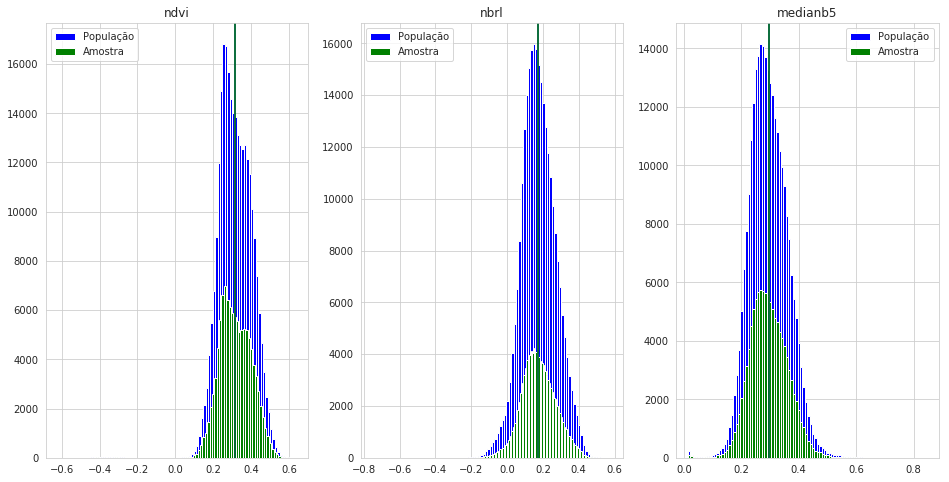

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,8))
# hist
plt.subplot(1, 3, 1)
plt.title('ndvi')
eixo = df3.ndvi.hist(bins=100, facecolor='b', label='População')
eixo = df3_amostra.ndvi.hist(bins=100, facecolor='g', label='Amostra')
eixo.axvline(df3.ndvi.mean(), c='b')
eixo.axvline(df3_amostra.ndvi.mean(), c='g')
plt.legend()

plt.subplot(1, 3, 2)
plt.title('nbrl')
eixo = df3.nbrl.hist(bins=100, facecolor='b', label='População')
eixo = df3_amostra.nbrl.hist(bins=100, facecolor='g', label='Amostra')
eixo.axvline(df3.nbrl.mean(), c='b')
eixo.axvline(df3_amostra.nbrl.mean(), c='g')
plt.legend()

plt.subplot(1, 3, 3)
plt.title('medianb5')
eixo = df3.medianb5.hist(bins=100, facecolor='b', label='População')
eixo = df3_amostra.medianb5.hist(bins=100, facecolor='g', label='Amostra')
eixo.axvline(df3.medianb5.mean(), c='b')
eixo.axvline(df3_amostra.medianb5.mean(), c='g')
plt.legend()

# Compara média e distribuição do NDVI dos conjuntos de QUEIMADA e NAO_QUEIMADA e AMOSTRA_NAO_QUEIMADA

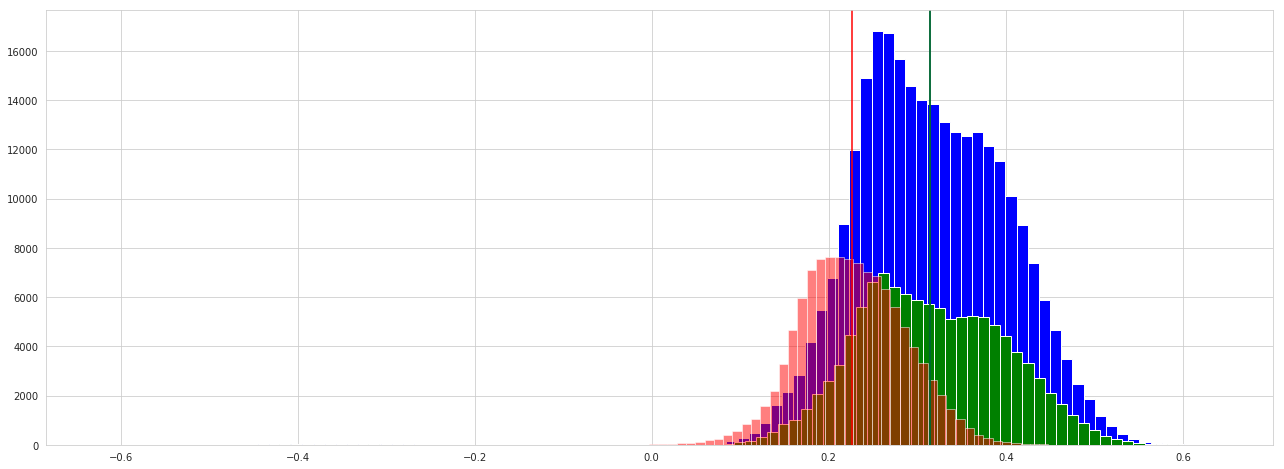

In [13]:
df3.ndvi.hist(bins=100, facecolor='b', figsize=(22,8))
df3_amostra.ndvi.hist(bins=100, facecolor='g')
ax = df1.ndvi.hist(bins=100, facecolor='r', alpha=0.5)
ax.axvline(df1.ndvi.mean(), c='r')
ax.axvline(df3.ndvi.mean(), c='b')
ax.axvline(df3_amostra.ndvi.mean(), c='g')

# Compara distribuição de NDVI em orb_pto diferentes

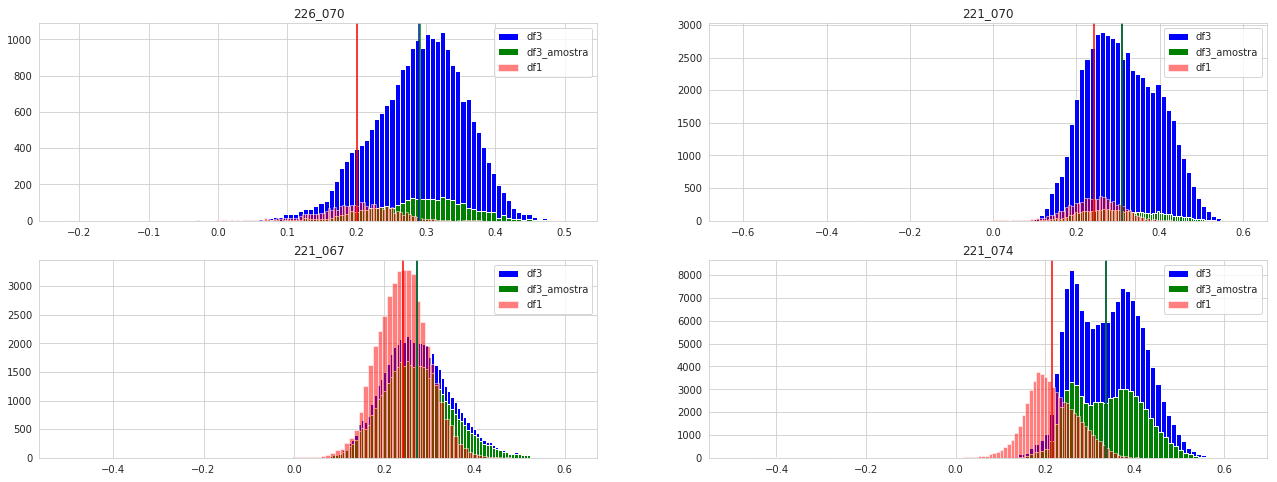

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
# hist

for k, op in enumerate(df.orb_pto.unique()):
    plt.subplot(2, 2, k+1)
    plt.title(op)
    temp1 = df1[df1.orb_pto==op]
    temp3 = df3[df3.orb_pto==op]
    temp3_amostra = gera_amostra_aleatoria(temp1, temp3)
    temp3.ndvi.hist(bins=100, facecolor='b', label='df3', figsize=(22,8))
    temp3_amostra.ndvi.hist(bins=100, facecolor='g', label='df3_amostra')
    ax = temp1.ndvi.hist(bins=100, facecolor='r', alpha=0.5, label='df1')
    ax.axvline(temp1.ndvi.mean(), c='r')
    ax.axvline(temp3.ndvi.mean(), c='b')
    ax.axvline(temp3_amostra.ndvi.mean(), c='g')
    plt.legend()


### Comparação de NDVI pre e pos fogo para cada orb_pto.

Para melhor visualização, foi usado a amostra de verifica 3

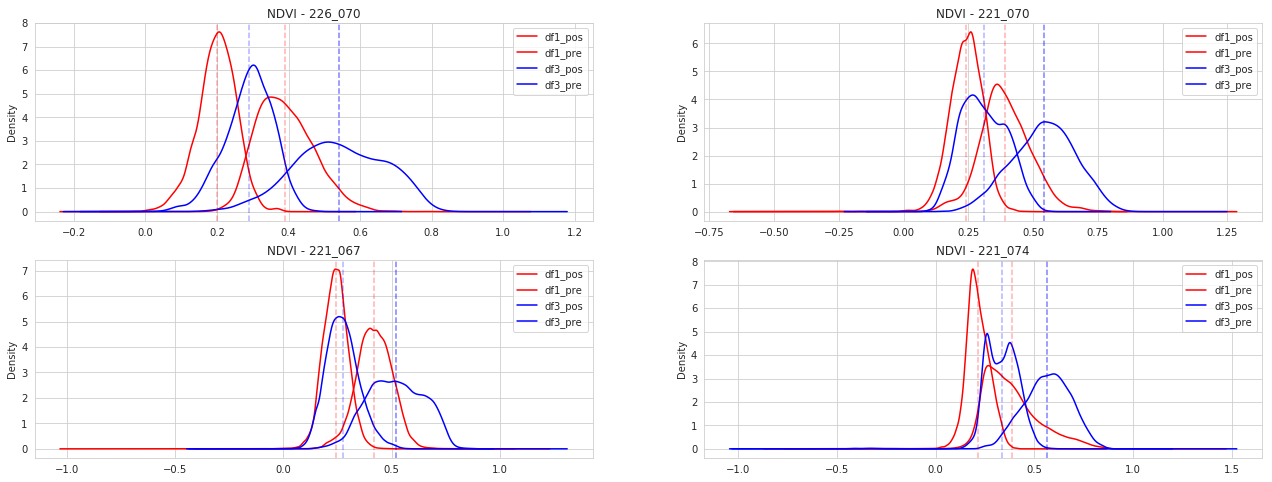

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
# hist

for k, op in enumerate(df.orb_pto.unique()):
    plt.subplot(2, 2, k+1)
    plt.title('NDVI - %s' % op)
    temp1 = df1[df1.orb_pto==op]
    temp3 = df3[df3.orb_pto==op]
    temp3 = gera_amostra_aleatoria(temp1, temp3)
    
    temp1.ndvi.plot.kde(c='r', label='df1_pos')
    temp1.ndvi_pre.plot.kde(c='r', label='df1_pre')
    
    temp3.ndvi.plot.kde(c='b', label='df3_pos')
    ax = temp3.ndvi_pre.plot.kde(c='b', label='df3_pre', figsize=(22,8))
    
    ax.axvline(temp1.ndvi.mean(), c='r', alpha=0.3, linestyle='--')
    ax.axvline(temp1.ndvi_pre.mean(), c='r', alpha=0.3, linestyle='--')
    ax.axvline(temp3.ndvi.mean(), c='b', alpha=0.3, linestyle='--')
    ax.axvline(temp3.ndvi_pre.mean(), c='b', alpha=0.5, linestyle='--')
    
    plt.legend()

# Lista todas cenas de uma orb_pto de um determinado ano
Neste exemplo, esta sendo filtrado os ID_CENAs da orb_pto 221_067 do ano de 2017

# * Apartir deste ponto, os dados observados serão somentes desta orb_pto/ano

In [16]:
df_221_067 = df[df.id_cena.str.contains('2210672017')]
id_cenas = sorted(df_221_067.id_cena.unique())
id_cenas

['LS82210672017125',
 'LS82210672017141',
 'LS82210672017157',
 'LS82210672017173',
 'LS82210672017189',
 'LS82210672017205',
 'LS82210672017221',
 'LS82210672017237',
 'LS82210672017253',
 'LS82210672017269',
 'LS82210672017285']

## Histograma NDVI e NBRL de cada passagem

    * Esta sendo plotado, a curva de densidade de queimada e nao_queimada
    * A amostra de nao_queimada não esta sendo gerada. Nesta orb_pto, o conjunto de queimada é maior que nao_queimada

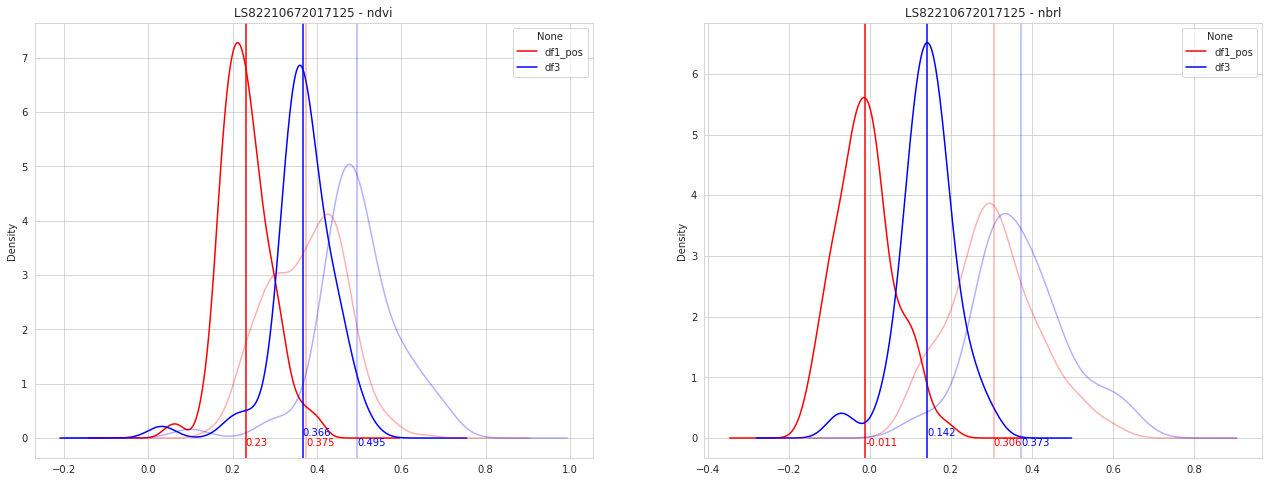

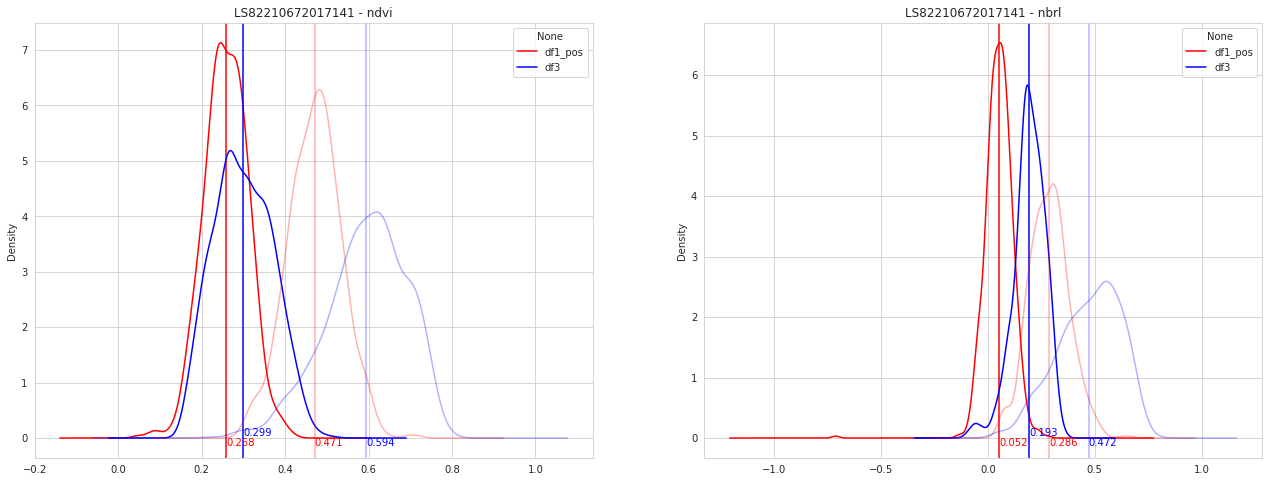

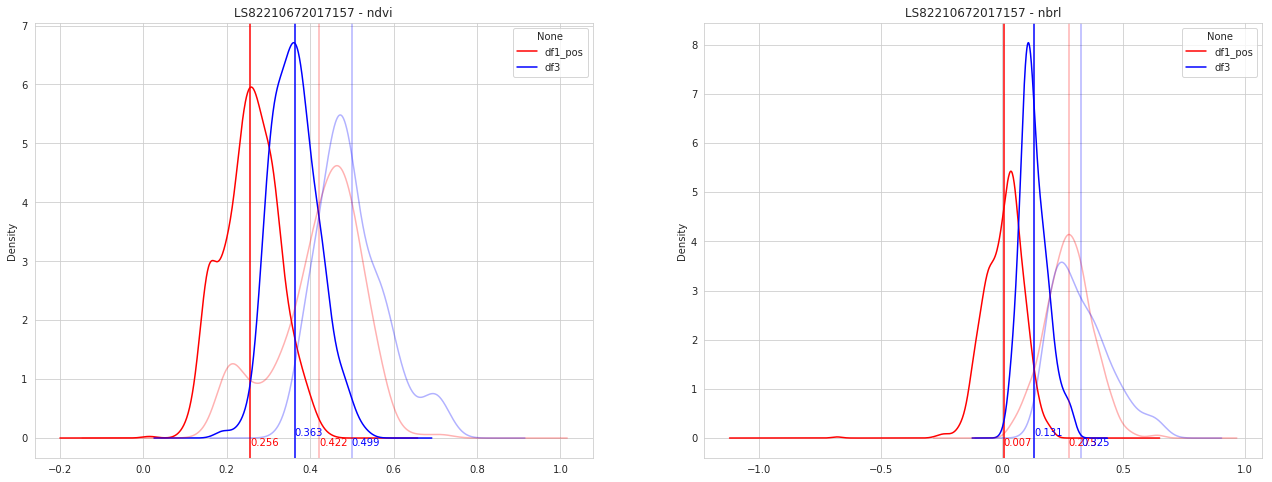

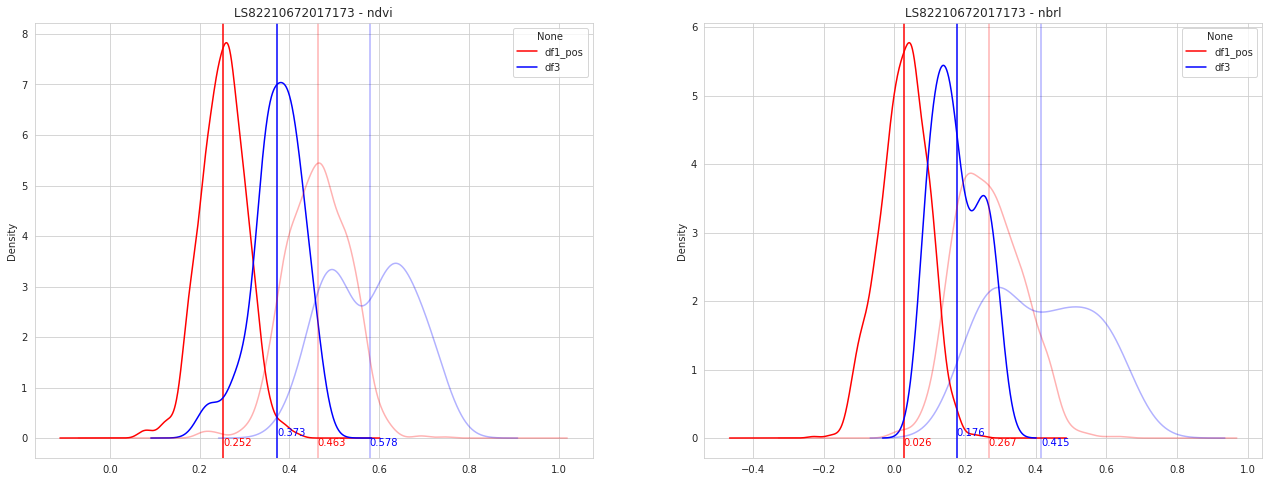

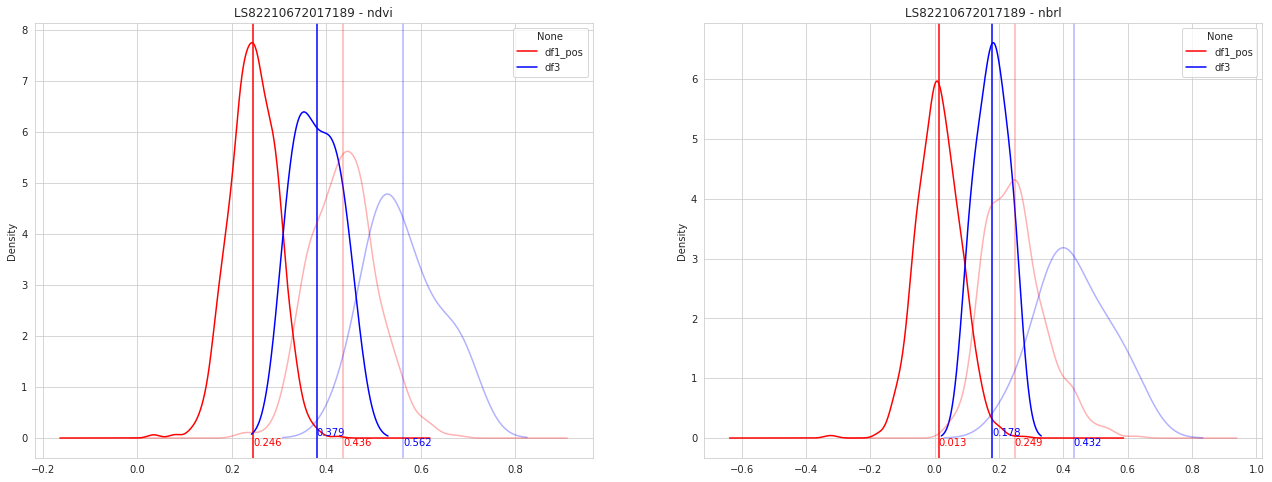

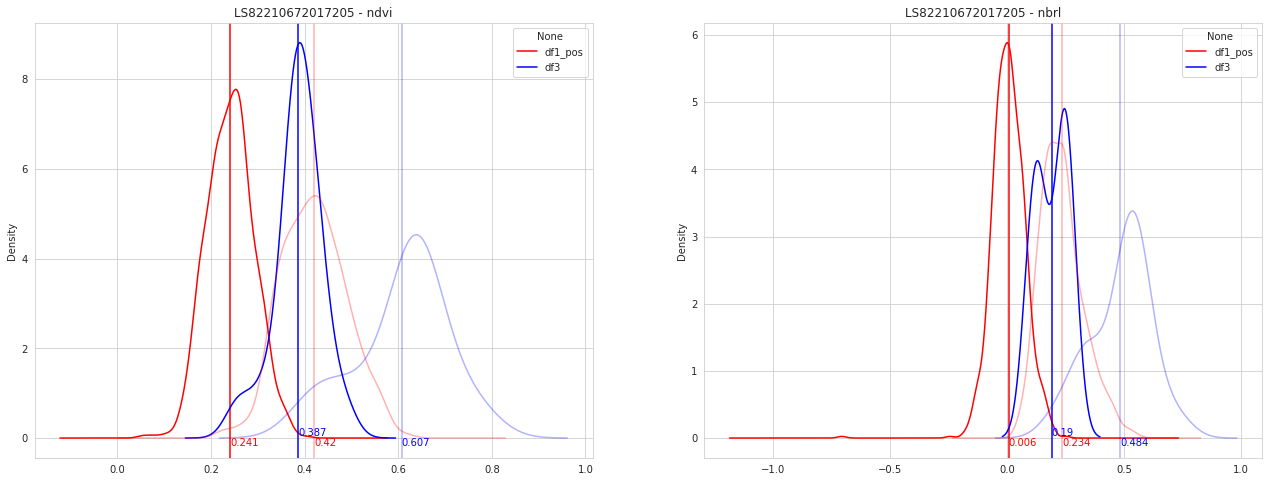

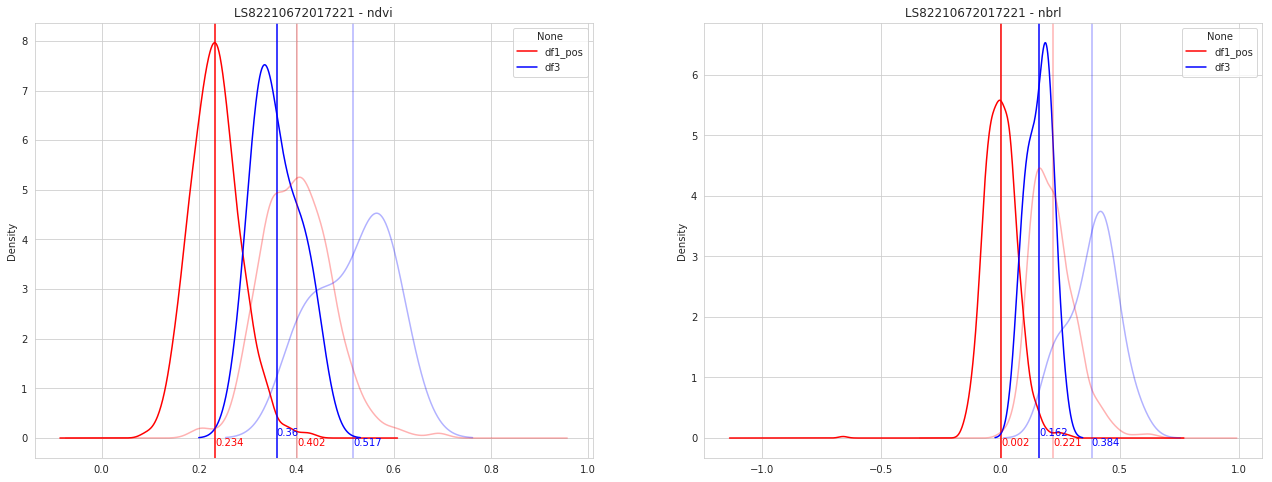

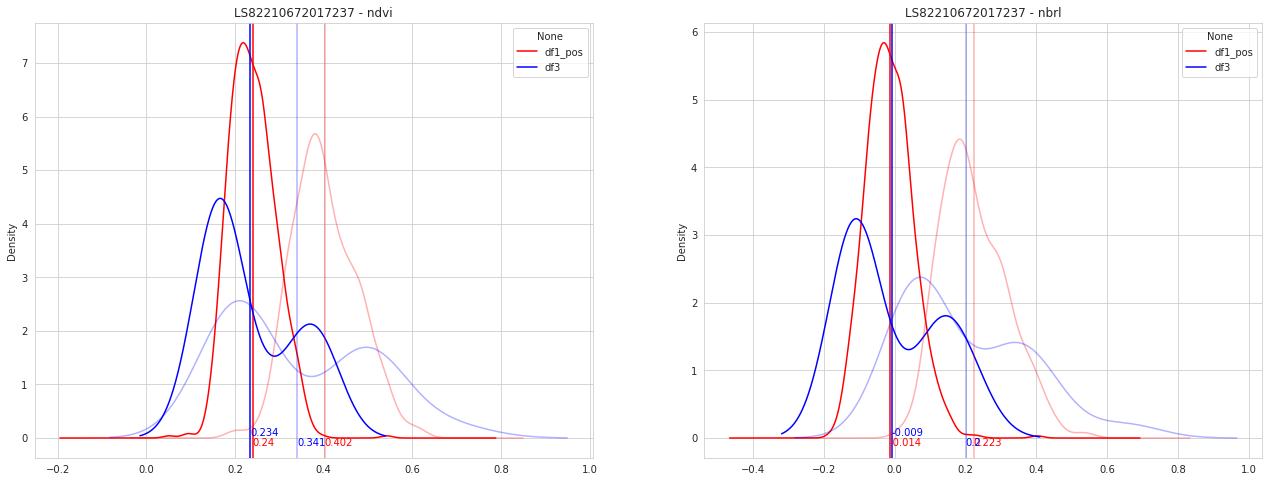

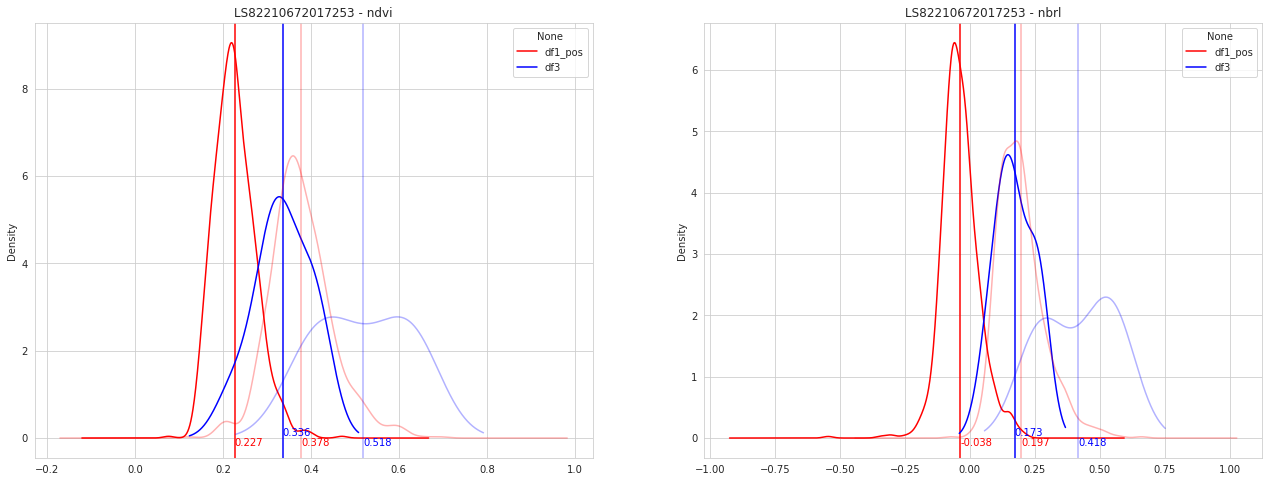

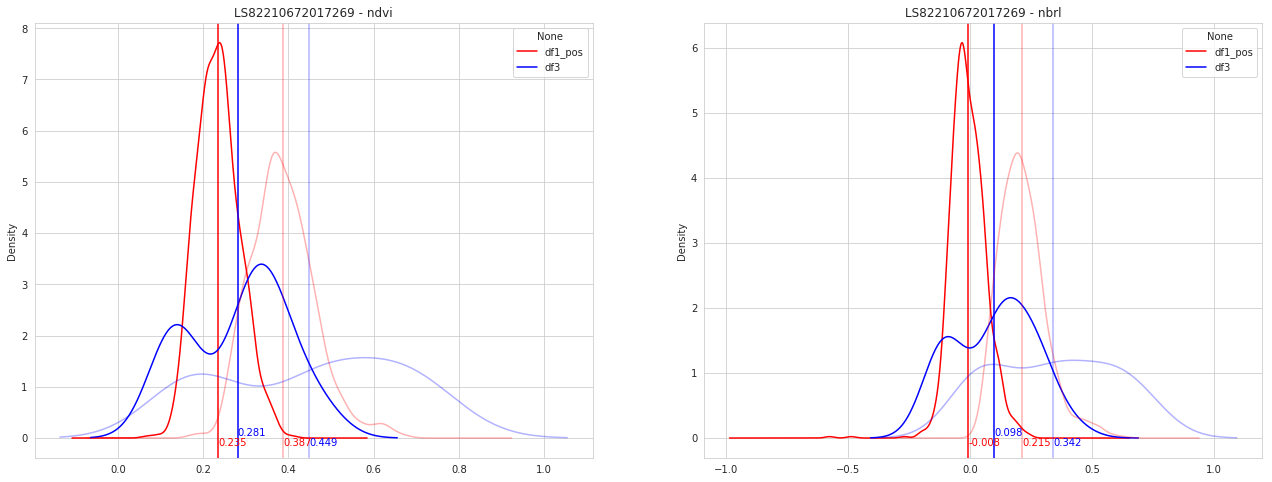

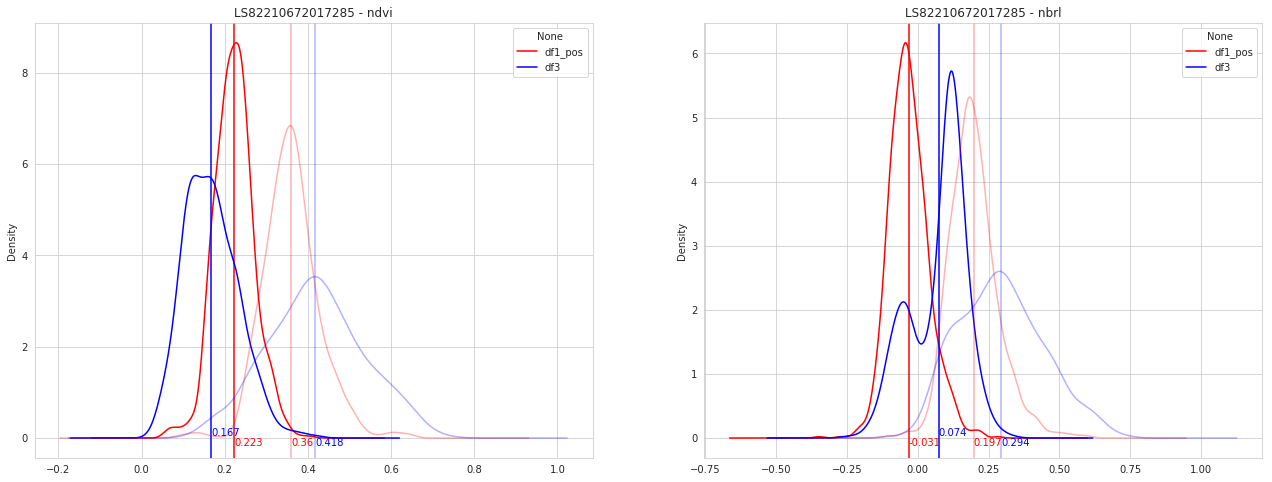

In [17]:
for i in id_cenas:
    fig, ax = plt.subplots(figsize=(22,8))
    d = df[df.id_cena==i].copy()
    d1 = d[d.verifica=='queimada']
    d3 = d[d.verifica=='nao_queimada']
    
    col = 'ndvi'
    plt.subplot(1, 2, 1)
    plt.title('%s - %s' % (i, col))
    ax = d1[col].plot.kde(c='r', label='df1_pos')
    plt.axvline(d1[col].mean(), c='r')
    ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')
    
    d3[col].plot.kde(c='b', label='df3')
    plt.axvline(d3[col].mean(), c='b')
    ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
    plt.legend()
    
    col = 'ndvi_pre'
    d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
    plt.axvline(d1[col].mean(), c='r', alpha=0.3)
    ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')
    
    d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
    plt.axvline(d3[col].mean(), c='b', alpha=0.3)
    ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='top')
    
    col = 'nbrl'
    plt.subplot(1, 2, 2)
    plt.title('%s - %s' % (i, col))
    ax = d1[col].plot.kde(c='r', label='df1_pos')
    plt.axvline(d1[col].mean(), c='r')
    ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')
    
    d3[col].plot.kde(c='b', label='df3')
    plt.axvline(d3[col].mean(), c='b')
    ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
    plt.legend()
    
    col = 'nbrl_pre'
    d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
    plt.axvline(d1[col].mean(), c='r', alpha=0.3)
    ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')
    
    d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
    plt.axvline(d3[col].mean(), c='b', alpha=0.3)
    ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='top')

# Graficos cruzando as combinações de colunas e suas correlações

In [18]:
paleta_cores = {'queimada': 'red', 'nao_queimada': 'blue'}

# Correlação

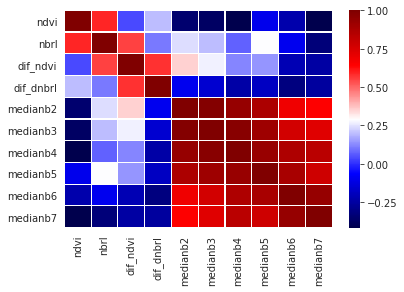

In [19]:
correlacao = df_221_067[colunas].corr()
sns.heatmap(correlacao, cmap='seismic', linecolor='white', linewidths=0.1)

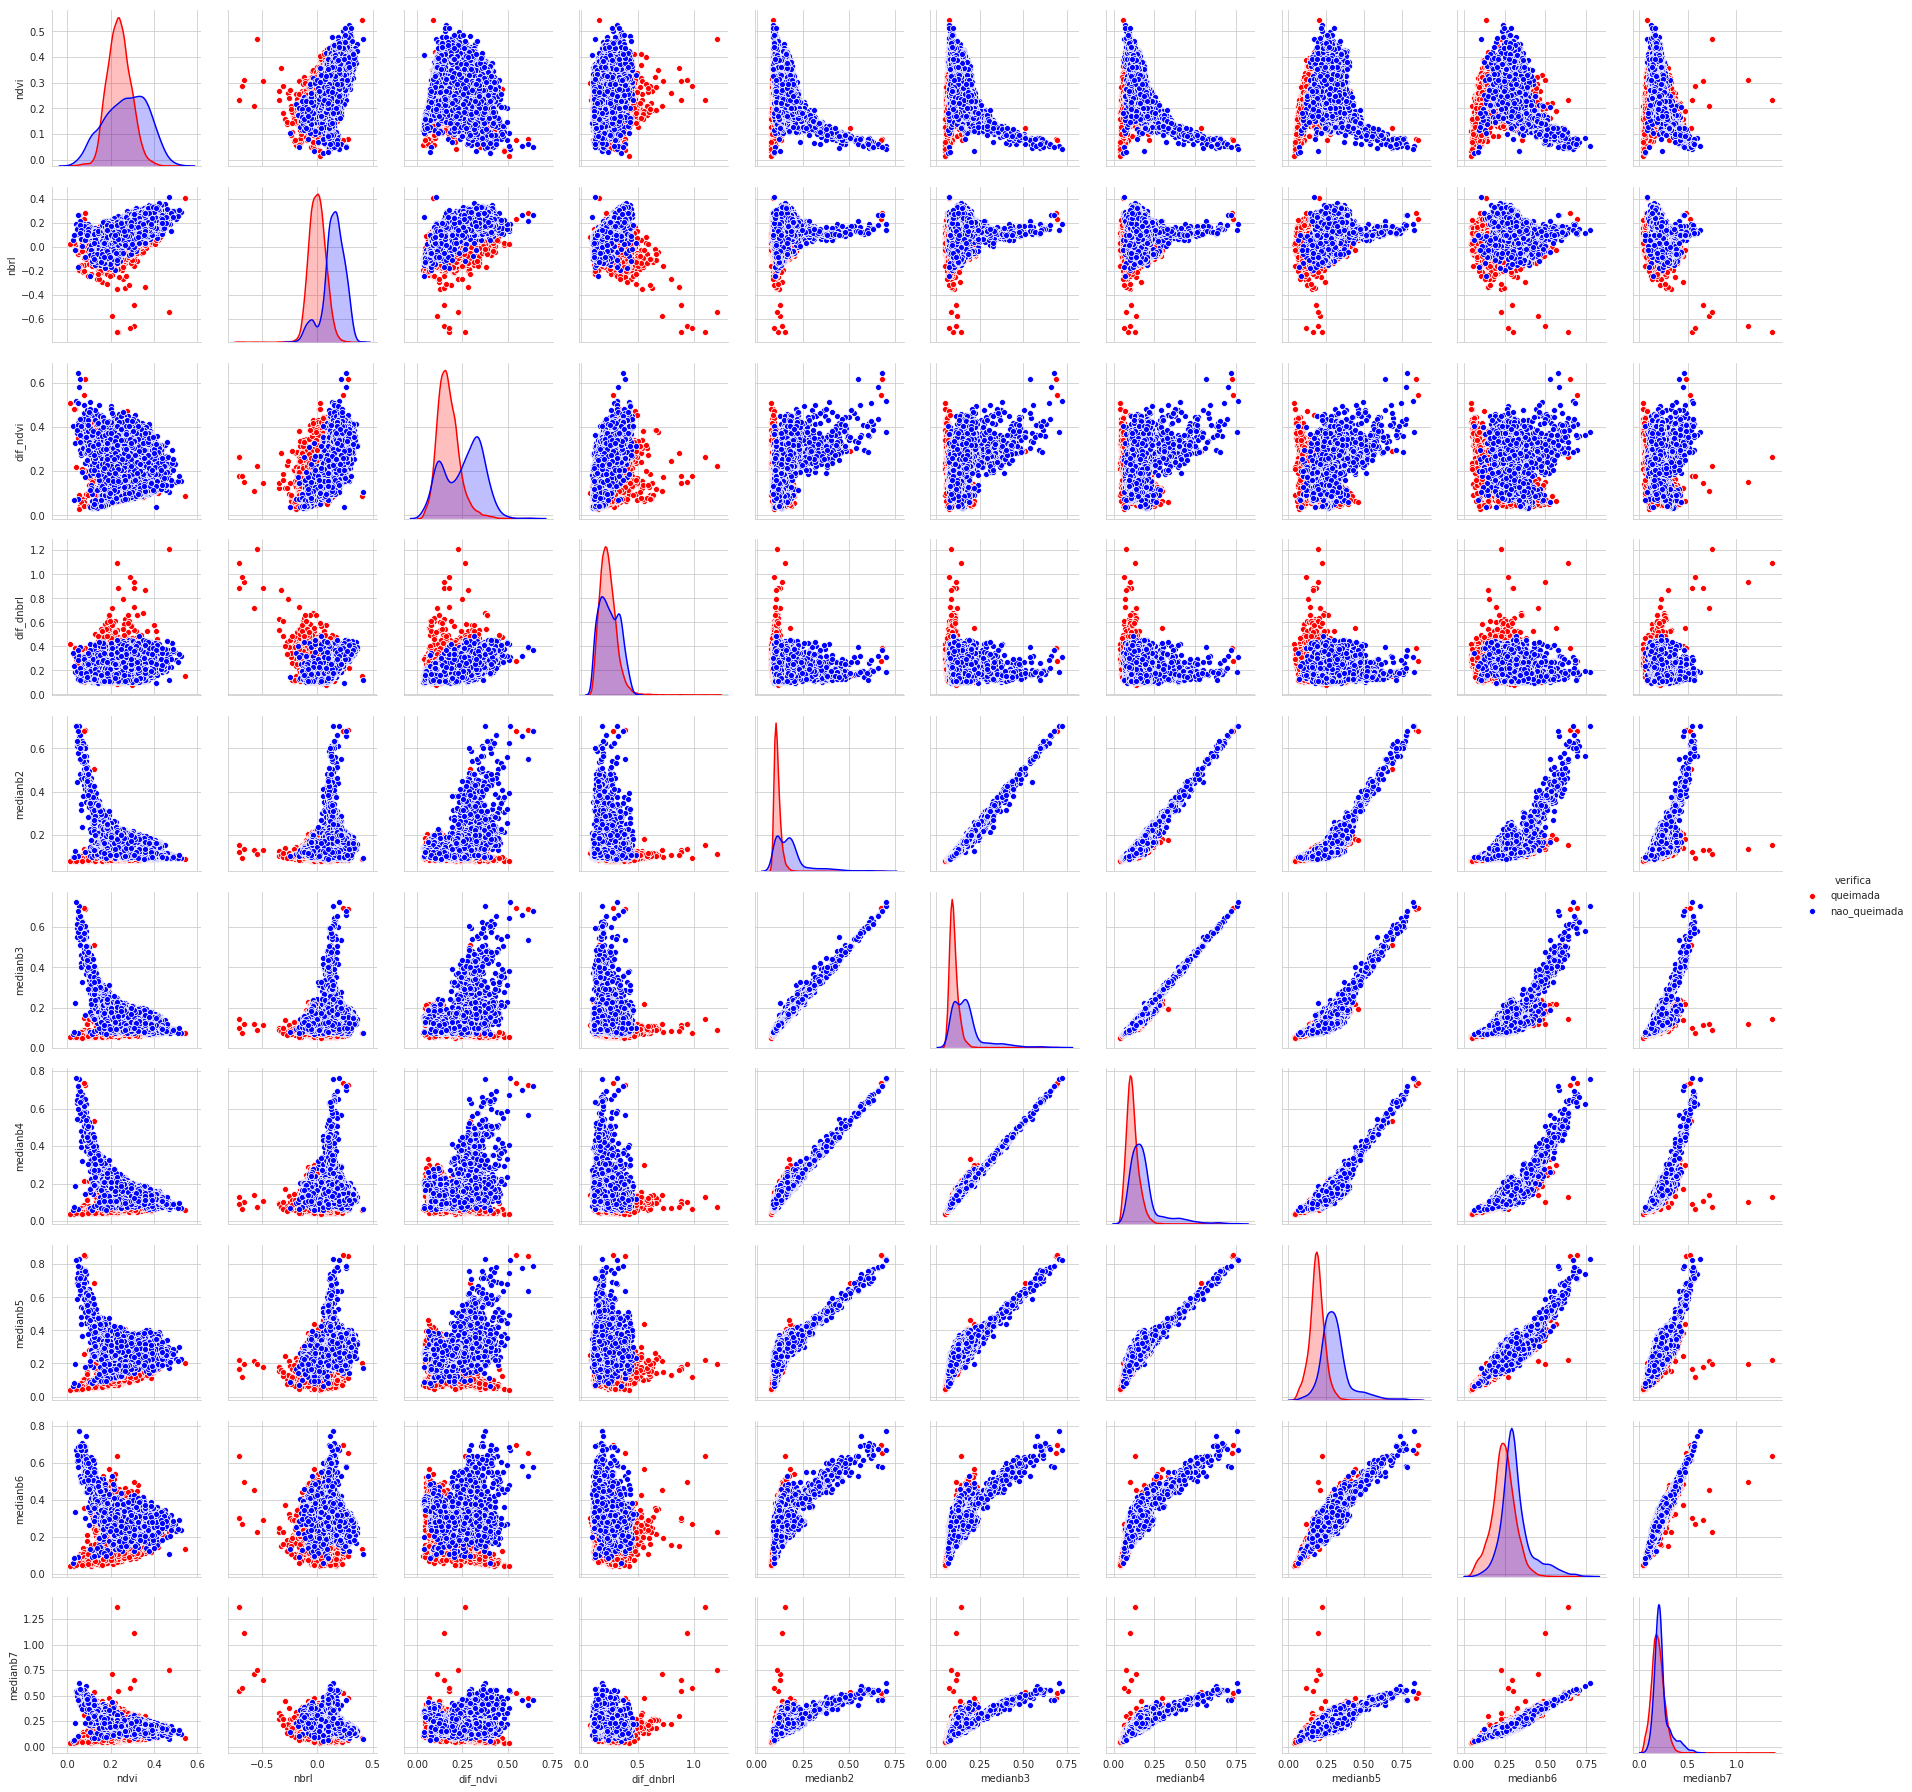

In [20]:
sns.pairplot(df_221_067[colunas+['verifica']], hue='verifica', palette=paleta_cores)

# Boxplot: Neste gráfico, tem 50% dos dados na parte colorida, e 25%+- nas extremidades. Os pontos mais externos são considerados outliers

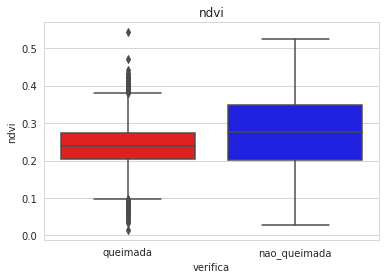

In [21]:
plt.title('ndvi')
sns.boxplot(data=df_221_067,x='verifica', y='ndvi', palette=paleta_cores)

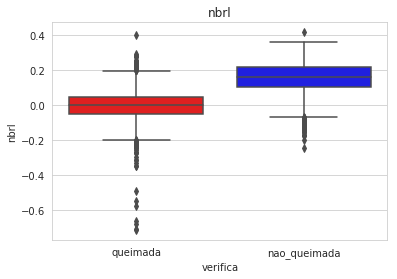

In [22]:
plt.title('nbrl')
sns.boxplot(data=df_221_067,x='verifica', y='nbrl', palette=paleta_cores)

# Regressão linear

/home/cicero/anaconda3/envs/aqml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


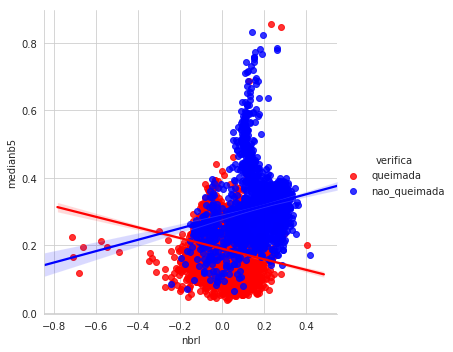

In [23]:
sns.lmplot(x='nbrl', y='medianb5', data=df_221_067, hue='verifica', palette=paleta_cores)

/home/cicero/anaconda3/envs/aqml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


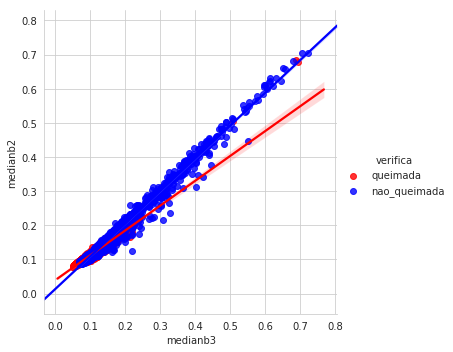

In [24]:
sns.lmplot(x='medianb3', y='medianb2', data=df_221_067, hue='verifica', palette=paleta_cores)

### Após a visualização dos dados, pode ser concluido que alguns atributos se misturam mais do que outros. Valendo testar a utilização de diferentes colunas baseado na sua relevância

# Testes dos modelos para realizar a classificação
    * ID_CENA escolhida: LS82210672017157
    * ID_CENA que aparenta ter uma média relação entre a diferença de queimada e nao_queimada
    (baseado nos gráficos acima)

Obs.: Em todos os modelos, os dados da cena que será classificada será sempre retirado do conhecimento.

# Seleciona a passagem para ser classificada

In [25]:
id_cena = 'LS82210672017157'

# Dado(DataFrame) que será classificado

In [26]:
teste = df_221_067[df_221_067.id_cena==id_cena].copy().reset_index(drop=True)

### Distribuição dos dados em queimada e nao_queimada do teste

In [27]:
print(teste.verifica.value_counts())

queimada        875
nao_queimada    177
Name: verifica, dtype: int64


### Histograma NDVI do dado de teste

Text(0.325372,0,'0.325')

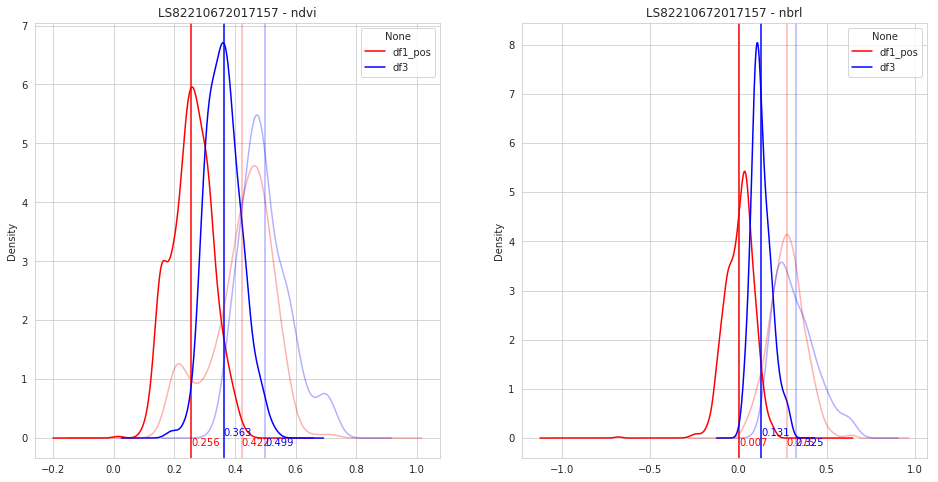

In [28]:
fig, ax = plt.subplots(figsize=(16,8))
d = teste.copy()
i = id_cena
d1 = d[d.verifica=='queimada']
d3 = d[d.verifica=='nao_queimada']

col = 'ndvi'
plt.subplot(1, 2, 1)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

col = 'ndvi_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='top')

col = 'nbrl'
plt.subplot(1, 2, 2)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

col = 'nbrl_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='top')

### 1º Teste: modelo com todas colunas e dados do ano inteiro da orb_pto

In [29]:
modelo = df_221_067[df_221_067['id_cena'] != id_cena]

### Distribuição dos dados em queimada e nao_queimada do modelo

In [30]:
print(modelo.verifica.value_counts())

queimada        8549
nao_queimada    1879
Name: verifica, dtype: int64


### Verifica se o id_cena escolhido esta no modelo de conhecimento

In [31]:
print(len(modelo[modelo.id_cena==id_cena]))

0


### Histograma NDVI do modelo de conhecimento

Text(0.407034,0,'0.407')

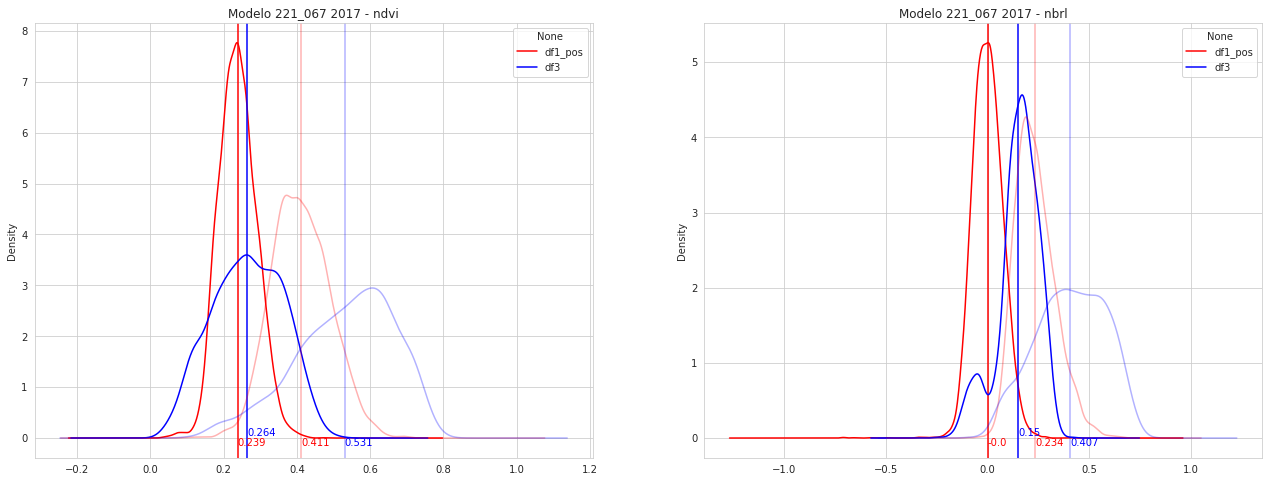

In [32]:
fig, ax = plt.subplots(figsize=(22,8))
i = 'Modelo 221_067 2017'
d = modelo.copy()
d1 = d[d.verifica=='queimada']
d3 = d[d.verifica=='nao_queimada']

col = 'ndvi'
plt.subplot(1, 2, 1)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

col = 'ndvi_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='top')

col = 'nbrl'
plt.subplot(1, 2, 2)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

col = 'nbrl_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='top')

## Cria classificador com Random Forest

In [33]:
classificador = RandomForestClassifier(n_jobs=8, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=8,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## Coeficiente GINI
GINI é um indice para definir a desigualdade, criado por um italiano estatistico, variando o valor de 0 a 1, onde:


    - Próximo de 0: Igualdade
    - Próximo de 1: Desigualdade

Para diferenciar dado de AREA_QUEIMADA e de NAO_AREA_QUEIMADA, é mais importante que ocorra a DESIGUALDADE, para que possa ter diferença significativa entre si dentro do mesmo conjunto de dado.

In [34]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,medianb2,0.489757
1,nbrl,0.286332
2,ndvi,0.110329
3,medianb5,0.093982
4,medianb3,0.009374
5,dif_ndvi,0.008478
6,medianb6,0.000640
7,medianb4,0.000596
8,dif_dnbrl,0.000512
9,medianb7,0.000000


### Classifica os dados

In [35]:
teste['rf'] = classificador.predict(teste[colunas])

### Cria funcao para ver o resultado somente de QUEIMADA

In [36]:
class_names = ['nao_queimada','queimada']

def ver_resultado(dado, coluna_previsao, coluna_verdade):
    queimada = 'queimada'
    nao_queimada = 'nao_queimada'
    try:
        d1 = dado[dado[coluna_verdade]==queimada]
        d2 = dado[dado[coluna_verdade]==nao_queimada]
        d3 = dado[(dado[coluna_previsao]==queimada) & (dado[coluna_verdade]==nao_queimada)]
        d4 = dado[(dado[coluna_previsao]==nao_queimada) & (dado[coluna_verdade]==queimada)]

        ax = d1.plot(kind='scatter', x='ndvi', y='nbrl', c='r', figsize=(22,8), label='1(%s)' % len(d1))
        d2.plot(kind='scatter', x='ndvi', y='nbrl', c='b', ax=ax, label='3(%s)' % len(d2))
        d3.plot(kind='scatter', x='ndvi', y='nbrl', c='r', ax=ax, marker='o', label='erro_1(%s)' % len(d3), s=50, facecolors='none', edgecolors='b')
        d4.plot(kind='scatter', x='ndvi', y='nbrl', c='b', ax=ax, marker='o', label='erro_3(%s)' % len(d4), s=50, facecolors='none', edgecolors='r')
        plt.legend()
        mostra_resultado(dado[coluna_previsao], dado[coluna_verdade])
    except Exception as e:
        print(e)
        return e
def mostra_resultado(y_true, y_pred):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Quantitativo')

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Porcentagem')

    plt.show()
    total_acertos = accuracy_score(y_true, y_pred, normalize=False)
    porcentagem_acertos = int(accuracy_score(y_true, y_pred)*100)
    print('Acertos: %s/%s (%s%%)' % (total_acertos, len(y_pred), porcentagem_acertos) )

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

Confusion matrix, without normalization
[[103  18]
 [ 74 857]]
Normalized confusion matrix
[[0.85123967 0.14876033]
 [0.07948443 0.92051557]]


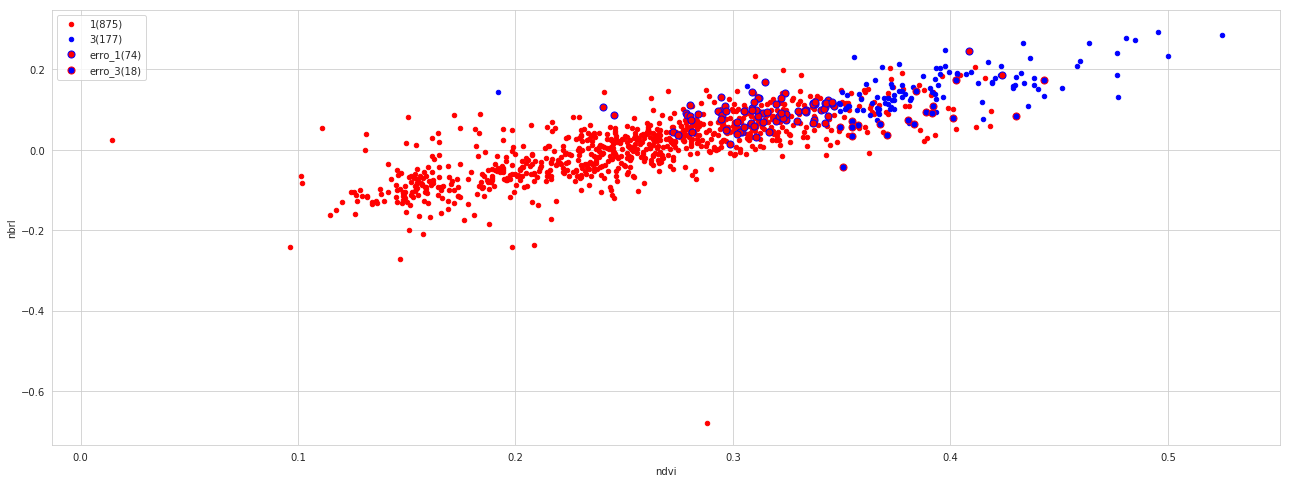

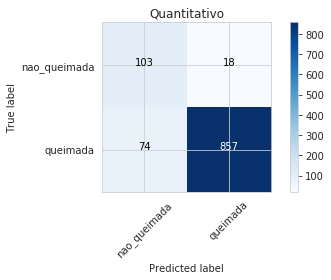

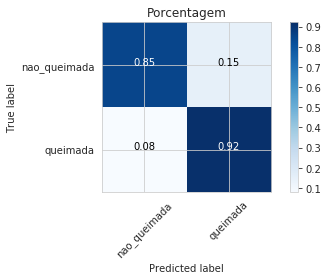

Acertos: 960/1052 (91%)


In [37]:
ver_resultado(teste, 'rf', 'verifica')

### 2º Teste: modelo com dados de todos os anos da mesma orb_pto e todas colunas

In [38]:
modelo = df[df.orb_pto=='221_067'].copy()

In [39]:
print(modelo.verifica.value_counts())

nao_queimada    55822
queimada        44235
Name: verifica, dtype: int64


### Anos no modelo

In [40]:
sorted(modelo.id_cena.str[-7:-3].unique())

['2002', '2003', '2011', '2013', '2015', '2016', '2017']

Text(0.426684,0,'0.427')

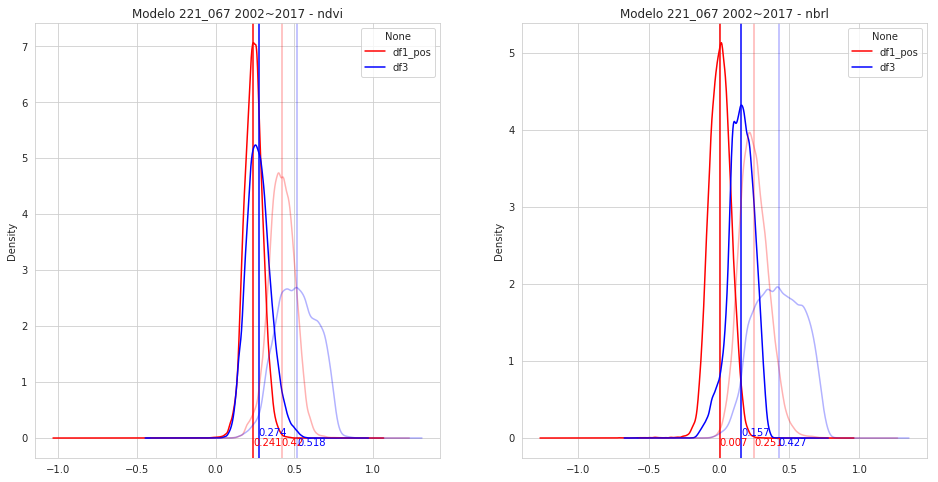

In [41]:
fig, ax = plt.subplots(figsize=(16,8))
d = modelo.copy()
i = 'Modelo 221_067 2002~2017'
d1 = d[d.verifica=='queimada']
d3 = d[d.verifica=='nao_queimada']

col = 'ndvi'
plt.subplot(1, 2, 1)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

col = 'ndvi_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='top')

col = 'nbrl'
plt.subplot(1, 2, 2)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

col = 'nbrl_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='top')

In [42]:
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [43]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,medianb2,0.414829
1,medianb5,0.340603
2,nbrl,0.212865
3,ndvi,0.023779
4,dif_ndvi,0.004757
5,medianb6,0.002507
6,medianb3,0.000661
7,dif_dnbrl,0.000000
8,medianb4,0.000000
9,medianb7,0.000000


In [44]:
teste['rf'] = classificador.predict(teste[colunas])

Confusion matrix, without normalization
[[165  30]
 [ 12 845]]
Normalized confusion matrix
[[0.84615385 0.15384615]
 [0.01400233 0.98599767]]


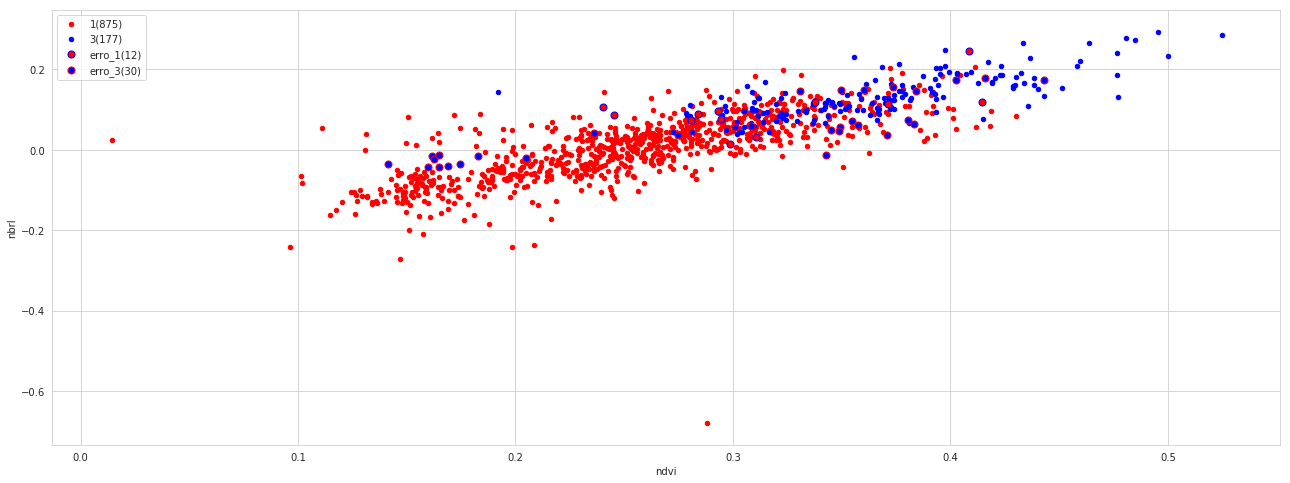

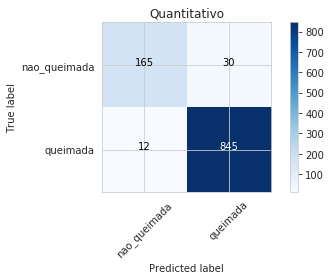

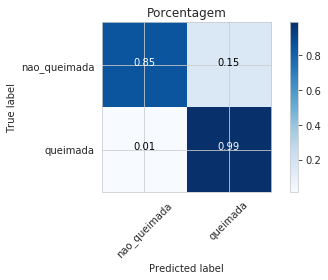

Acertos: 1010/1052 (96%)


In [45]:
ver_resultado(teste, 'rf', 'verifica')

### 3º Teste: modelo dados do trimestre da mesma orb_pto e todas colunas

In [46]:
modelo['dia'] = modelo.id_cena.str[-3:].astype(int)
orb_pto = '221_067'
dia = int(id_cena[-3:])

modelo = modelo[modelo.dia.isin(range(dia-90, dia+90))].copy()

In [47]:
print(modelo.verifica.value_counts())

queimada        30588
nao_queimada    25075
Name: verifica, dtype: int64


Text(0.436719,0,'0.437')

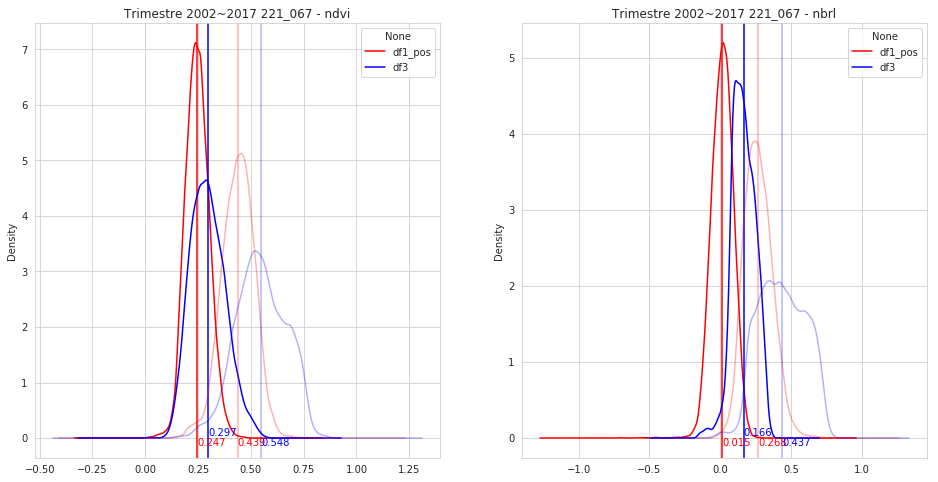

In [48]:
fig, ax = plt.subplots(figsize=(16,8))
d = modelo.copy()
i = 'Trimestre 2002~2017 221_067'
d1 = d[d.verifica=='queimada']
d3 = d[d.verifica=='nao_queimada']

col = 'ndvi'
plt.subplot(1, 2, 1)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

col = 'ndvi_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='top')

col = 'nbrl'
plt.subplot(1, 2, 2)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

col = 'nbrl_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='top')

In [49]:
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [50]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,medianb5,0.671616
1,nbrl,0.306011
2,ndvi,0.016412
3,medianb3,0.003185
4,medianb6,0.002775
5,dif_ndvi,0.000000
6,dif_dnbrl,0.000000
7,medianb2,0.000000
8,medianb4,0.000000
9,medianb7,0.000000


In [51]:
teste['rf'] = classificador.predict(teste[colunas])

Confusion matrix, without normalization
[[162  42]
 [ 15 833]]
Normalized confusion matrix
[[0.79411765 0.20588235]
 [0.01768868 0.98231132]]


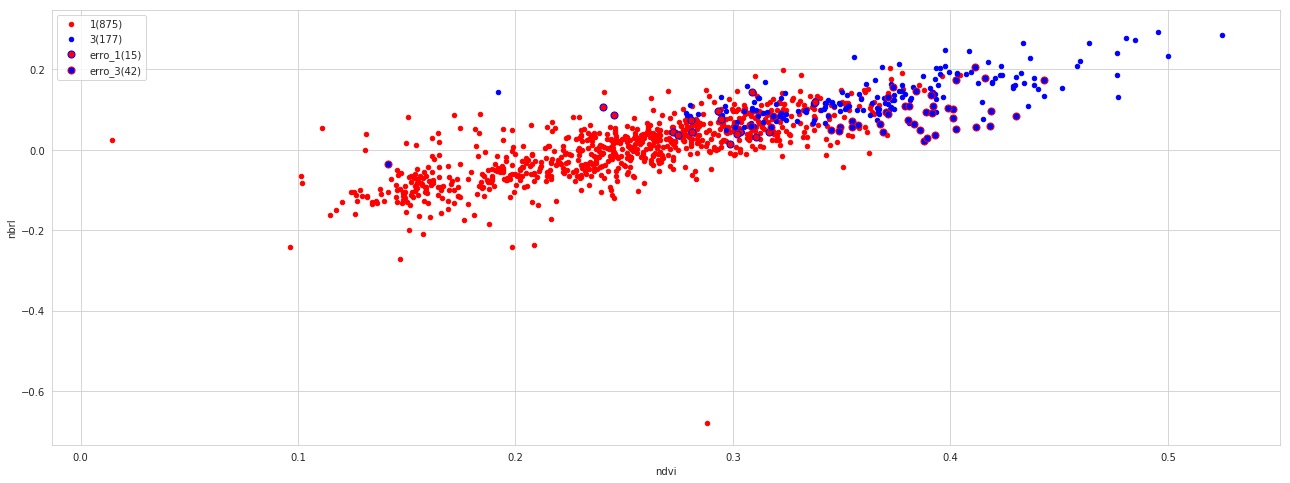

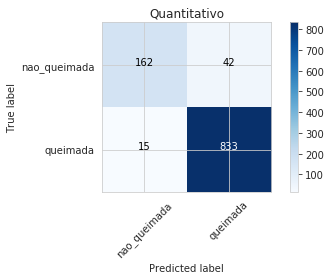

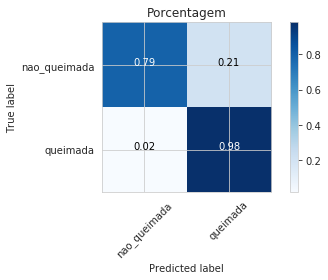

Acertos: 995/1052 (94%)


In [52]:
ver_resultado(teste, 'rf', 'verifica')

### 4º Teste: modelo dados do trimestre da mesma orb_pto e todas colunas - Aumenta número de arvores

In [53]:
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [54]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,medianb5,0.670904
1,nbrl,0.306701
2,ndvi,0.016664
3,medianb3,0.003412
4,medianb6,0.002319
5,dif_ndvi,0.000000
6,dif_dnbrl,0.000000
7,medianb2,0.000000
8,medianb4,0.000000
9,medianb7,0.000000


In [55]:
teste['rf'] = classificador.predict(teste[colunas])

Confusion matrix, without normalization
[[162  39]
 [ 15 836]]
Normalized confusion matrix
[[0.80597015 0.19402985]
 [0.01762632 0.98237368]]


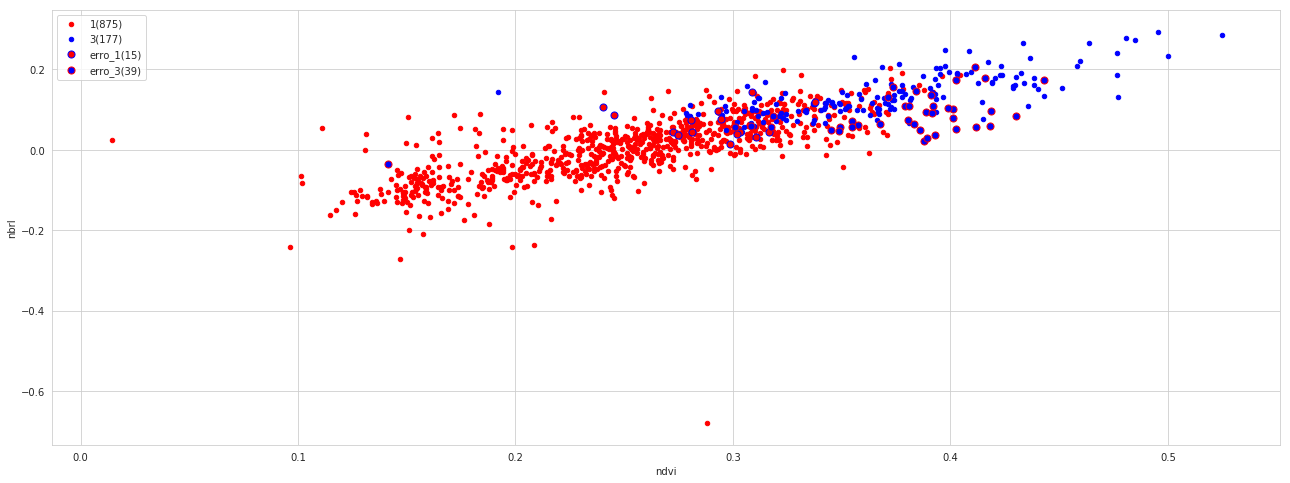

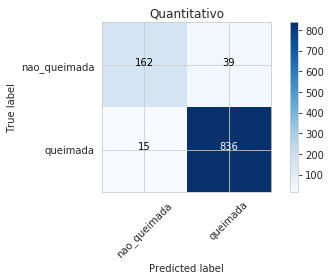

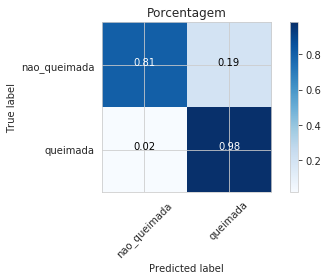

Acertos: 998/1052 (94%)


In [56]:
ver_resultado(teste, 'rf', 'verifica')

### 5º Teste: modelo dados do trimestre da mesma orb_pto e todas colunas - diminui número de arvores

In [57]:
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=10, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [58]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,medianb5,0.670622
1,nbrl,0.307338
2,ndvi,0.015382
3,medianb3,0.004775
4,medianb6,0.001883
5,dif_ndvi,0.000000
6,dif_dnbrl,0.000000
7,medianb2,0.000000
8,medianb4,0.000000
9,medianb7,0.000000


In [59]:
teste['rf'] = classificador.predict(teste[colunas])

Confusion matrix, without normalization
[[160  43]
 [ 17 832]]
Normalized confusion matrix
[[0.78817734 0.21182266]
 [0.02002356 0.97997644]]


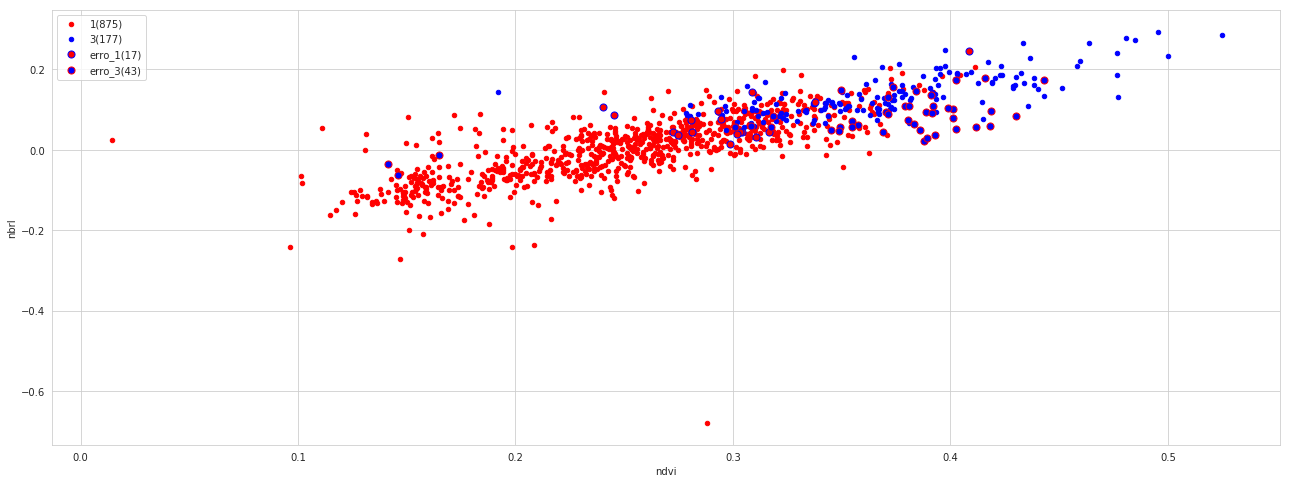

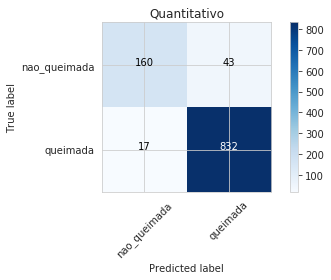

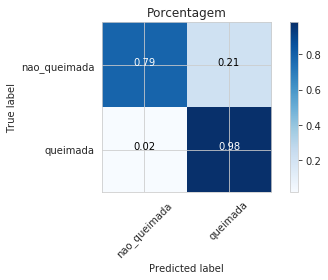

Acertos: 992/1052 (94%)


In [60]:
ver_resultado(teste, 'rf', 'verifica')

### 6º Teste: modelo dados do trimestre da mesma orb_pto e 2 colunas: nbrl e medianb5

In [61]:
colunas = ['nbrl', 'medianb5']
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [62]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,medianb5,0.688655
1,nbrl,0.311345


In [63]:
teste['rf'] = classificador.predict(teste[colunas])

Confusion matrix, without normalization
[[159  18]
 [ 18 857]]
Normalized confusion matrix
[[0.89830508 0.10169492]
 [0.02057143 0.97942857]]


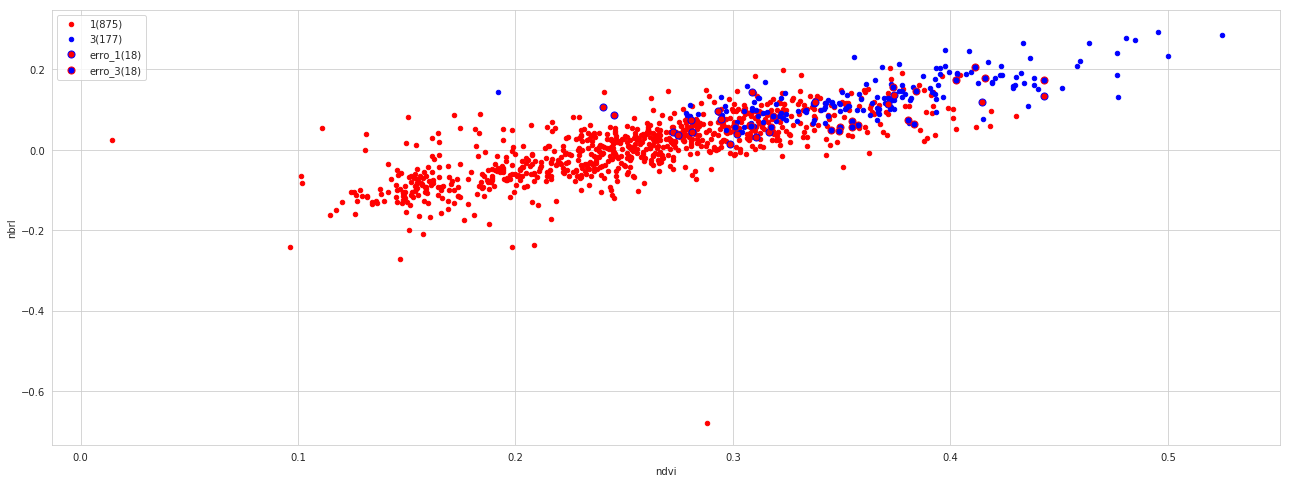

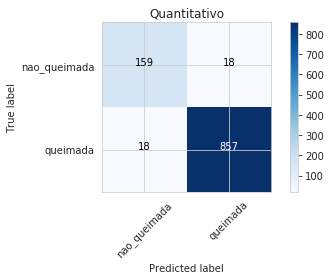

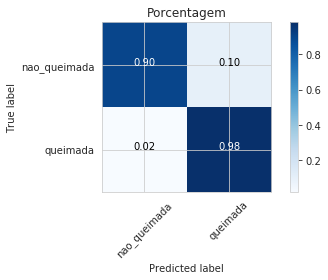

Acertos: 1016/1052 (96%)


In [64]:
ver_resultado(teste, 'rf', 'verifica')

### 7º Teste: modelo dados do trimestre da mesma orb_pto e 2 colunas: medianb6 e medianb7

In [65]:
colunas = ['medianb3', 'medianb2']
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [66]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,medianb2,0.966416
1,medianb3,0.033584


In [67]:
teste['rf'] = classificador.predict(teste[colunas])

Confusion matrix, without normalization
[[ 16  62]
 [161 813]]
Normalized confusion matrix
[[0.20512821 0.79487179]
 [0.16529774 0.83470226]]


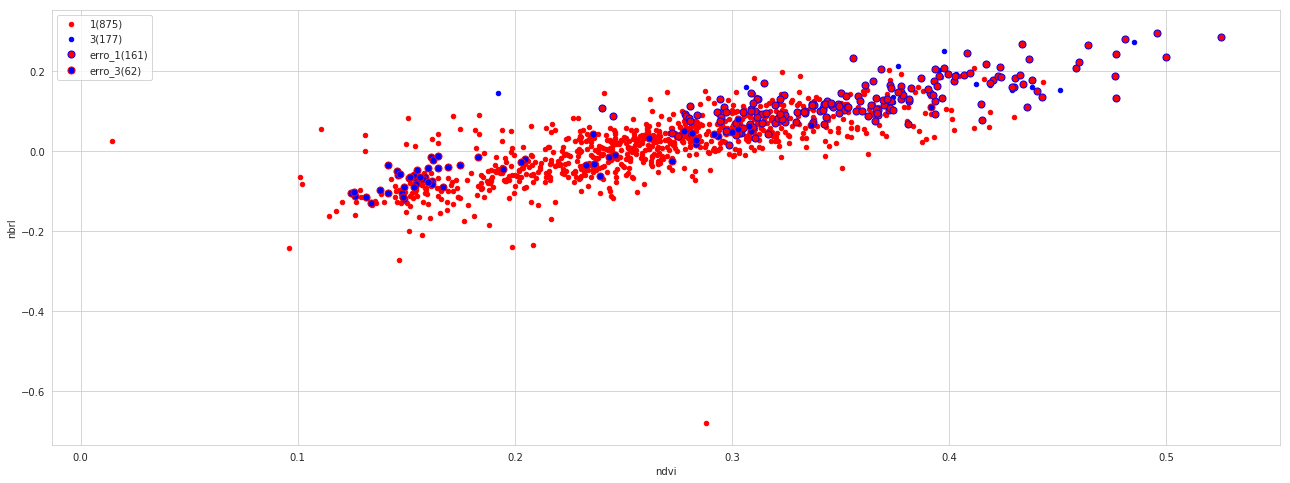

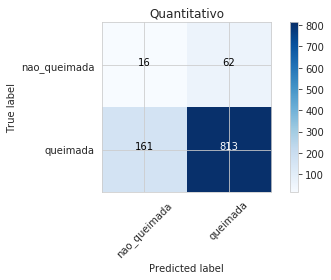

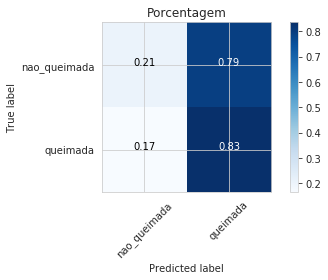

Acertos: 829/1052 (78%)


In [68]:
ver_resultado(teste, 'rf', 'verifica')